In [183]:
######################### This version is meant to be a clone or Dr.Orlandi's version. Using his psych curve etc. goal is to clone behaviour. Will Implement objects.
######################### And then modify from there 
#gonna work in radians

In [184]:
#imports
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random
from numba import jit

In [185]:
################### GLOBAL VARIABLES
NUMANGLES = 8 #how many orientations each side can take
MAXPROB = .95

TRIALSPERANGLE = 1

NUMDIFFBINS = 10

ANGLEMAX = np.pi/2
ANGLEMIN = -np.pi/2

MAX_EPOCHS = 1 # Total epochs
BATCH_SIZE = 40000 # Trials per batch

NOCHOICEVAL = 1
LEFTCHOICEVAL = 0  #Value output when choosing left bar
RIGHTCHOICEVAL = 2 #Value output when choosing right bar

UNITS = 256 # Number of neurons in the dense layer
OUTPUT_SIZE = 3 # Number of output states
INPUT_DIMENSION = 3 #dimension of input. it will be 3 when there is attention included into model. 

ANGLE_DIMENSION = 2

STIMULUSDURATION = 1.5 #length of the stimulus (seconds)
PRESTIMULUSDURATION = 1 #length of the pre stimulus (seconds)

ONECHOICE = False #whether makes one choice and sticks or changes mind

FRAMERATE = 10 #(hz)

TOTALFRAMES = int(FRAMERATE*(STIMULUSDURATION + PRESTIMULUSDURATION)) #total number of frames

LASTFRAME = TOTALFRAMES - 1 #Index of last frame

ATTENTION_LEVELS = [0,1]  # Binary attention, currently -> low (0) or high (1)

PRESTIMULUSFRAME = int(PRESTIMULUSDURATION * FRAMERATE) - 1
STIMULUS_FRAME = PRESTIMULUSFRAME + 1
#################################################

In [186]:
class timeSeries:
    '''Class whose objects are times series of an instance'''
    
    def __init__(self, series):
        '''Initialization method. Stores an input list'''
        self.tSeries = series

In [187]:
class aTrial:
    '''Objects of this class represent a single trial'''
    
    def __init__(self, inputSeries, outputSeries, decider, info):
        self.inputSeries = inputSeries 
        self.outputSeries = outputSeries
        self.decisionAgent = decider
        self.info = info

In [188]:
class anglePair:
    '''Class whose objects are pairs of angles'''

    def __init__(self, angle1, angle2):
        '''Initialization method stores 2 input angles to the instance'''
        self.angle1 = angle1
        self.angle2 = angle2

In [189]:
class trialInfo:

    def __init__(self, angSep,pCertain,correctCh, difficultyBin):
        self.angSep = angSep
        self.pCertain = pCertain
        self.correctCh = correctCh
        self.difficultyBin = difficultyBin


In [190]:
class frameInfo:

    def __init__(self, angSep,pCertain,correctCh):
        self.angSep = angSep
        self.pCertain = pCertain
        self.correctCh = correctCh


In [191]:
class decisionMaker:
    '''Class that represents the agent making the decision'''

    def __init__(self, attention):
        '''initialization method sets the attention level of the instance'''
        self.attention = attention

    def _sameSign(self, angles):
        '''given a list of two angles the method return True if the angles have same sign. False if the angles have opposite sign'''
        angle1 = angles[0]
        angle2 = angles[1]
        return not abs(angle1 + angle2) < abs(angle1)+abs(angle2)

    def _difficulty(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

        beta = 0.03 #slope parameter for steepness of difficulty curve (a function of angle separation)

        #Set the y intercept of the inverse hyperbolic tangent
        if self.attention == 0:
            alpha = .5 #Alpha is the value of y intercept of the tanh. Also the value of the difficulty of an infinite angle separation. Make it higher for low attention
        elif self.attention == 1:
            alpha = 0.3 #Make it lower for high attention

        #offset to shift the graph so at x = 0 arctanh(g(x)) is alpha
        offset = np.arctanh( 2*alpha - 1 )/beta 

        #Scaling Parameter. relates to d(difficulty)/d(angle separation)
        f = .08 
        if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            f = f - y*f 
        
        #scale it so small differences are large value and big differences are small. Map 0 to inf and inf to zero.                 
        x = 1/(f*difference) 

        #Calculate and return difficulty
        dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )

        return dif

    def correctChoice(self, angles):
        '''input 2 angles return the smaller angle corresponding to more vertical orientation
        Angle 1 is left angle 2 is right. Returns -1 for Left 1 for right
        if they are equal error is thrown because currently only training on non equal angles
        '''
        global LEFTCHOICEVAL, RIGHTCHOICEVAL
        angle1 = angles[0]
        angle2 = angles[1]

        if abs(angle1) < abs(angle2):
            #The left bar is oriented more vertically
            return LEFTCHOICEVAL        
            
        elif abs(angle2) < abs(angle1):
            #The right bar is oriented more vertically
            return RIGHTCHOICEVAL       
        
        else:
            #throw error if angles are equal
            print("WEHAVEANERROR")
            return "Error. Not expecting equal angles" 
        
    def trainedChoice(self, angles):
        '''Input two angles returns the choice the mouse makes'''
        global MAXPROB, LEFTCHOICEVAL, RIGHTCHOICEVAL

        #Calculate the probability that the decision maker is certain
        pCertain = self._probablilityCertain(self._difficulty(angles))

        #Check if the probCertain is larger than the maximum allowed certainty
        if pCertain > MAXPROB:
            #If probability certain is larger than the max allowed, then set it to the max
            pCertain = MAXPROB
        
        #Calculate the correct choice. (more vertically oriented)    
        cor = self.correctChoice(angles)
        
        angDif = ( abs(angles[0]) - abs(angles[1]) )
        
        info = frameInfo(angDif, pCertain, cor)
       
        #Generate a random number in [0,1) and use it to determin whether the decision maker is certain or not
        n = random.random()

        if n < pCertain: #they are certain
            #The decision maker is certain so return the correct answer
            return cor, info
            
        else:#not certain then it is a guess
            #generate a random number in [0,1) to decide which side the decision maker guesses
            g = np.random.random()
            if g < .5:
                #return the correct choice
                return cor, info
            else:
                #return the other choice
                if cor == RIGHTCHOICEVAL:
                    return LEFTCHOICEVAL, info
                else:
                    return RIGHTCHOICEVAL, info
                
    def _probablilityCertain(self, difficulty):
        '''return the probability of being certain as a function of difficulty'''
        #difficulty goes from 1 to 0. this flips it and maps a high difficulty to a low probability of being chosen
        p = -difficulty + 1
        return p

In [192]:
class timeSeriesCreationMachine:
    '''This class has objects that are machines to create time series. it will have configuration options and a method that spits out time series'''

    def createInputTimeSeries(self, anglePair):                                                                                                                    
        '''Input: ([angle1, angle2], attention)
           Output: timeSeries corresponding to input to network
             '''
        inputTimeSeries = timeSeries(np.zeros((TOTALFRAMES, ANGLE_DIMENSION)).astype(np.float32)) #stores the trials time series'

        inputTimeSeries.tSeries[STIMULUS_FRAME:, 0] = anglePair[0]
        inputTimeSeries.tSeries[STIMULUS_FRAME:, 1] = anglePair[1]

        #Parameter that scales the temporal noise
        temporalNoiseScale = (NUMANGLES/np.pi) * 15
       
        #The number of stimulus frames
        num_frames = inputTimeSeries.tSeries.shape[0]

        # Generate random noise for each frame
        noise_0 = np.random.randn(num_frames) / temporalNoiseScale
        noise_1 = np.random.randn(num_frames) / temporalNoiseScale

        # Apply noise to the corresponding frames
        inputTimeSeries.tSeries[:, 0] += noise_0
        inputTimeSeries.tSeries[:, 1] += noise_1

        #return the time series
        return inputTimeSeries
    
    def findBin(self, domainStart, domainStop, numBins, value):
        '''domain start is the start of the interval the histogram is defined on.
         domain end is the end of the interval. If it was a histogram of adult heights then start would be lowest height and stop be largest height
         numBins is the number of bins there are
          value is the value you want to determine which bin it is in.
           if my interval was from 0 to 1 and i had two bins then 0.2 would be in bin 0.  '''
        
        dx = abs(domainStop - domainStart)/numBins
        bin = int(value / dx)
        return bin
                    
    def createOutputTimeSeries(self, inputTimeSeries, oneChoice, decisionAgent):
        '''Input: the input time series, attention level, bool that determines if decisionMaker makes multiple choices
           Output: An output time series that is meant to be the desired output of the network when recieving the input time series'''
      
        #Initialize the response time series
        outputTimeSeries = timeSeries(np.full((TOTALFRAMES), np.nan)) 

        infoLength = int(round(STIMULUSDURATION*FRAMERATE,0))

        angSep = np.zeros(infoLength)
        pCert = np.zeros(infoLength)
        correctCh = np.zeros(infoLength)
  
        #Go through frames and create output time series
        for frame in range(TOTALFRAMES): 
            if frame < PRESTIMULUSFRAME: 
                outputTimeSeries.tSeries[frame] = np.nan
            elif frame == PRESTIMULUSFRAME:
                outputTimeSeries.tSeries[frame] = NOCHOICEVAL
            elif frame == STIMULUS_FRAME:
                firstTrainedChoice, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame])
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                angSep[frame - STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - STIMULUS_FRAME] = frameInformation.pCertain 
                correctCh[frame - STIMULUS_FRAME] = frameInformation.correctCh
              
            elif oneChoice == True:#when one choice is True one choice is made when stim is shown and that choice remains. when False It makes a decision each frame.
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                angSep[frame - STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - STIMULUS_FRAME] = frameInformation.pCertain
                correctCh[frame - STIMULUS_FRAME] = frameInformation.correctCh

            else:
                #use the angles corresponding to stimulus builds a distribution
                trainedChoice, frameInformation = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame])
                outputTimeSeries.tSeries[frame] = trainedChoice
                angSep[frame - STIMULUS_FRAME] = frameInformation.angSep
                pCert[frame - STIMULUS_FRAME] = frameInformation.pCertain
                correctCh[frame - STIMULUS_FRAME] = frameInformation.correctCh

        ####AVERAGE INFO
        angSep = np.average(angSep)
        pCert = np.average(pCert)
        correctCh = np.average(correctCh)
        #info = np.array([angSep,pCert,correctCh])

        
        val = abs(angSep)

        difficultyBin = self.findBin(0, ANGLEMAX, NUMDIFFBINS, val)


        info = trialInfo(angSep,pCert,correctCh, difficultyBin)


        return outputTimeSeries, info                                                                                                          

In [193]:
class ensembleCreator:
    '''uses the timeSeriesCreator class to create an ensemble of iteration time series'''

    
    
    def genAngles(self):
          #Generate a list of valid angles for one side
        angleList = np.linspace(ANGLEMAX, ANGLEMIN, NUMANGLES)

        decimals = 2
        angles_grid = np.meshgrid(angleList, angleList)
        i_values = angles_grid[0].ravel()
        j_values = angles_grid[1].ravel()
        mask = (np.round(i_values, decimals) != np.round(j_values, decimals)) & (-np.round(i_values, decimals) != np.round(j_values, decimals))
       
        i_values = i_values[mask]
        j_values = j_values[mask]
        noiseScale = (NUMANGLES/np.pi) * 30
        i_values += np.random.randn(len(i_values)) / noiseScale
        j_values += np.random.randn(len(j_values)) / noiseScale

        anglePairs = np.column_stack((j_values, i_values))
        
        #Randomize the order
        np.random.shuffle(anglePairs)

        return anglePairs
    
    def generateEnsemble(self, attention):
        '''Input: An attention level, numBins is number of difficulty levels
           Output: An ensemble of input and output time series corresponding to the input attention level. 
           (The input is what is fed into the network and the output is the desired network response)'''
        
        
        anglePairs = self.genAngles()

        #Determine the number of trials 
        numberTrials = len(anglePairs)

        #Instantiate a timeSeriesCreator
        timeSeriesCreator = timeSeriesCreationMachine()

        #Initialize a list to store this ensembles trials
        trialList = np.zeros(numberTrials).astype(aTrial)

     
        #Go through the trials and for each trial create an input and output time series
        for trial in range(numberTrials):
            #create input time series
            inputTimeSer = timeSeriesCreator.createInputTimeSeries(anglePairs[trial]) 
            
            decisionAgent = decisionMaker(attention)

            #create output time series
            outputTimeSer, informat = timeSeriesCreator.createOutputTimeSeries(inputTimeSer ,ONECHOICE, decisionAgent )

            trialHere = aTrial(inputTimeSer, outputTimeSer, decisionAgent, informat)
            
            trialList[trial] = trialHere

    
        return trialList
    
    def generateEnsembles(self, attentionList):
        '''Input: a list of attention levels
           Output: an ensemble of trials at each attention level'''
        
        #Boolean representing if it is the first attention level. If first then a new list needs to be created. else the existing list should be appended to
        first = True

        #Boolean to catch the first time running at second attention level
        firstSecondTime = True

        
        sortedTrialsData = np.full(len(attentionList),np.nan, dtype=object)

        #for each attention level create an ensemble of trials
        for j in range(TRIALSPERANGLE):
            c = 0
            for attentionLevel in attentionList:
                trialsData = self.generateEnsemble(attentionLevel)

                if first:
                    allTrialsData = trialsData
                    first = False

                else:
                    allTrialsData =  np.concatenate((allTrialsData, trialsData), axis = 0)
                    
                c +=1

        np.random.shuffle(allTrialsData)
        
        return allTrialsData, sortedTrialsData

In [194]:
class netModel:

    def __init__(self):
        '''initialization method. Initializes instance attributes'''

        self.trialsData = np.nan

        self.inputTrainingData = np.nan
        self.inputTestData = np.nan

        self.responseTrainingData = np.nan
        self.responseTestData = np.nan

        self.testDifData = np.nan
        self.trainDifData = np.nan

        self.testResponse = np.nan

        self.model = np.nan

        self.isFit = False

    def _custom_loss(self, y_actual,y_pred): 
        '''calculates the loss using the frame immediately before stimulus and last frame of time series
        The frame before stim is to set p left and p right = 0'''
        l1 = kb.sparse_categorical_crossentropy(y_actual[:, PRESTIMULUSFRAME], y_pred[:, PRESTIMULUSFRAME])
        l2 = kb.sparse_categorical_crossentropy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
        custom_loss = l1 + l2
        return custom_loss

    def _custom_cat(self, y_actual,y_pred):
        '''Checks the accuracy of the final predicted output and compares it to the desired output'''
        l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
        custom_cat = l2
        return custom_cat
    
    def genData(self):
        '''generates and stores the training/testing data for the network'''
        ensembleGen = ensembleCreator()

        self.trialsData, self.binnedTrials = ensembleGen.generateEnsembles(ATTENTION_LEVELS)
        
    def splitData(self):
        '''splits and stores the data into training and test sets'''
       
        if np.isnan(self.trialsData[0].inputSeries.tSeries).any(): #MAKE BETTER
            print("You must generate data before it can be split")

        else:
            inputTrialsData = np.zeros((len(self.trialsData),TOTALFRAMES,INPUT_DIMENSION))

            trialsResponseData = np.zeros((len(self.trialsData), TOTALFRAMES))

            trialDifficultyData = np.zeros(len(self.trialsData))
            


            c = 0
            for tri in self.trialsData:
                att = np.zeros(len(tri.inputSeries.tSeries))
                att += tri.decisionAgent.attention
                
                tri.inputSeries.tSeries= np.hstack((tri.inputSeries.tSeries, np.expand_dims(att, axis=1)))
                inputTrialsData[c] = tri.inputSeries.tSeries
                trialsResponseData[c] = tri.outputSeries.tSeries
                trialDifficultyData[c] = tri.info.difficultyBin

                c += 1

            xTrain, xTest, yTrain, yTest, difTrain, difTest = sk.train_test_split(
                                                            inputTrialsData, 
                                                            trialsResponseData,
                                                            trialDifficultyData, 
                                                            test_size=0.25, 
                                                            random_state=None
                                                            )
            self.inputTestData = xTest
            self.inputTrainingData = xTrain
            self.responseTestData = yTest
            self.responseTrainingData = yTrain
            self.testDifData = difTest
            self.trainDifData = difTrain

    def genModel(self):
        '''creates and stores the model'''
        if np.isnan(self.trialsData[0].inputSeries.tSeries).any():
            print("Please generate and split your data before creating the model")
        else:
            model = keras.models.Sequential()
            model.add(
                        Input(
                                shape = (
                                            TOTALFRAMES, 
                                            INPUT_DIMENSION
                                            )
                                )
                        )
            model.add(layers.SimpleRNN(UNITS, activation = 'relu', return_sequences = True, name = 'rnn'))
            model.add(layers.BatchNormalization(name = 'batch_norm'))
            model.add(layers.Dense(OUTPUT_SIZE, activation = 'softmax', name = 'outputprobs'))

        
            metrr = ['accuracy', self._custom_cat]

            model.compile(
                            loss=self._custom_loss,
                            optimizer="adam",
                            metrics=metrr
                            )
            
            self.model = model

    def trainModel(self):
        '''trains the model using generated training data'''
        if np.equal(self.model, np.nan):
            "Please create the model before you can train it"
        else:
            self.model.fit(
                        self.inputTrainingData, 
                        self.responseTrainingData, 
                        epochs = MAX_EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        verbose = True, 
                        validation_data = (
                                            self.inputTestData, 
                                            self.responseTestData
                                            )
                        )
            self.isFit = True
            

    def genTestOutput(self):
        '''generates a test output from test input once model is trained'''
        if self.isFit:
            self.testResponse = self.model.predict(self.inputTestData)
        else:
            print("Please create and train the model first")
        
    
    def plotTestResponse(self):
        '''plots a sample of test responses for low and high attention'''
        if np.isnan(self.testResponse).any():
            print("Please generate a test output first")
        else:
            indexHighAtt = []
            indexLowAtt = []
            
            for i in range(NUMDIFFBINS):
                indexHighAtt.append([])
                indexLowAtt.append([])



            for i in range(len(self.inputTestData)):
                if self.inputTestData[i][0][2] == 0: #low att
                    indexLowAtt[int(self.testDifData[i])].append(i)
                else:
                    indexHighAtt[int(self.testDifData[i])].append(i)
            
            row2 = []
            row1 = []
            dif2 = []
            dif1 = []
            numCol = 4
            for i in range(numCol):
                g = True
                c = 0
                while g:
                    difficulty = int(random.sample(range(NUMDIFFBINS),1 )[0])
                    #print(indexLowAtt[difficulty], indexHighAtt[difficulty])
                    if (len(indexLowAtt[difficulty])>0) & (len(indexHighAtt[difficulty])>0):
                        highAttIndex = random.sample(indexHighAtt[difficulty], 1)[0]
                        lowAttIndex = random.sample(indexLowAtt[difficulty], 1)[0]
                        if (not (np.equal(row1, highAttIndex).any())) & (not (np.equal(row2, lowAttIndex).any())):
                            row2.append(lowAttIndex)
                            row1.append(highAttIndex)
                            dif2.append(difficulty)
                            dif1.append(difficulty)
                            g = False
                    else:
                        g = True
                    c += 1
                    if c > 1000:
                        print("ERROR")
                        break

            print(row2, "index low attention trials plotted")
            print(row1, "index of high attention trials plotted")

            print(dif2, "difficulty low attention trials plotted")
            print(dif1, "difficulty high attention trials plotted")

            fig, ax = plt.subplots(2, numCol, sharex = True, sharey = True, figsize = (20,10))


            fig.tight_layout(pad=3.0)

            for i in range(len(row1)):
                l1 = []
                l2 = []
                l3 = []
                for j in self.testResponse[row1[i]]: 
                    l1.append(j[0])
                    l2.append(j[1])
                    l3.append(j[2])
            
                ax[0][i].plot(l1)        #PLOT the high attention trials
                ax[0][i].plot(l2)
                ax[0][i].plot(l3)
            for i in range(len(row2)):
                l1 = []
                l2 = []
                l3 = []
                for j in self.testResponse[row2[i]]:
                    l1.append(j[0])
                    l2.append(j[1])
                    l3.append(j[2])
                    
                ax[1][i].plot(l1)     #Plot the low attention trials
                ax[1][i].plot(l2)
                ax[1][i].plot(l3)

           
            ax[0,0].set_title("High Attention Trials")
            ax[1,0].set_title("Low Attention Trials")
            plt.show()


    def plotPsychCurve(self):
        '''plots the predicted and actual psych curves'''

        #create subplots for graphing data
        fig, ax = plt.subplots(3,1, sharex = True,sharey = False, figsize = (10,10))

        #list to store angle differences
        angDifference = []

        #list to store probabilty of certainty as a function of angle difference
        probCertain = []

        #list to store probabilty of choosing left as a function of angle difference
        pLeft = []

        #list to store probabilty of choosing right as a function of angle difference
        pRight = []
        
        #go through trials and store probability of choosing left and right based on certainty and the correct choice
        for trialNow in self.trialsData:
            for choice in trialNow.outputSeries.tSeries:
                #if not (np.isnan(inf[0]) & np.isnan(inf[1])):
                if True: #CHANGE LATER
                    angDif = trialNow.info.angSep
                    pCert = trialNow.info.pCertain
                    cor = trialNow.info.correctCh
                    angDifference.append(angDif) #angDif
                    probCertain.append(pCert) #pCertain
                    

                    #inf[2] is correct choice
                    #if correct choice is left then chance left is % certainty + .5*(1- % certainty). because val of certainty you are correct and (1-certainty) its a 50/50 guess
                    if cor == LEFTCHOICEVAL:
                        pLeftVal = pCert + .5*(1- pCert)
                        pRightVal = 1 - pLeftVal

                    #same as above but right is the correct choice
                    elif cor == RIGHTCHOICEVAL:
                        pRightVal = pCert + .5*(1- pCert)
                        pLeftVal = 1 - pRightVal

                    #you have chosen something invalid
                    else:
                        print("Error")
                    
                    #Store the prob choose left and prob choose right
                    pLeft.append(pLeftVal)
                    pRight.append(pRightVal)

                    
        
        #set titles
        ax[0].set_title("prob left predict")
        ax[1].set_title("prob right predict")
   
        #plot p left and p right
        ax[0].plot(angDifference,pLeft, 'or', markersize = 0.3)
        ax[1].plot(angDifference,pRight, 'ob', markersize = 0.3)
        ax[2].hist(angDifference, 10000)
        ax[2].set_ylim(0, 3)


        
        #Create lists for histogram data
        probRightListHighAttSameSignCorrect = []
        probRightListLowAttSameSignCorrect = []
        probRightListHighAttOppSignCorrect = []
        probRightListLowAttOppSignCorrect = []

        probLeftListHighAttSameSignCorrect = []
        probLeftListLowAttSameSignCorrect = []
        probLeftListHighAttOppSignCorrect = []
        probLeftListLowAttOppSignCorrect = []

        probRightListHighAttSameSignInCorrect = []
        probRightListLowAttSameSignInCorrect = []
        probRightListHighAttOppSignInCorrect = []
        probRightListLowAttOppSignInCorrect = []

        probLeftListHighAttSameSignInCorrect = []
        probLeftListLowAttSameSignInCorrect = []
        probLeftListHighAttOppSignInCorrect = []
        probLeftListLowAttOppSignInCorrect = []
        

        highAttSameSignAngListRight = []
        lowAttSameSignAngListRight = []
        highAttOppSignAngListRight = []
        lowAttOppSignAngListRight = []
        highAttSameSignAngListLeft = []
        lowAttSameSignAngListLeft = []
        highAttOppSignAngListLeft = []
        lowAttOppSignAngListLeft = []
        
        #counter variable
        counter = 0

        #Boolean representing if angles are equal sign
        SameSign = True
 

        #go through the output data and create normalized histograms
        for trial in self.responseTestData:
            #Empty list to store trial info
            trialList = []
            
            #Go through choices made during stimulus duration
            for frame in trial:
                #ensure the frame is a stimulus frame
                if ( (not(np.isnan(frame))) & (not(float(frame) == 1.0))):
                    trialList.append(frame)
                    
          

            #Variable to store how many times left was chosen
            leftCount = 0 

            #variable to store how many times right was chosen
            rightCount = 0       

            #Go through data and store how many counts of each
            for i in trialList:
                if i == LEFTCHOICEVAL:
                    leftCount += 1
                else:
                    rightCount += 1

            numDecision = len(trialList)# num frames

            #find probabilities from data
            probLeft = leftCount/numDecision
            probRight = rightCount/numDecision

            #store the angles and the difference of their abs values
            angle1 = self.inputTestData[counter][STIMULUS_FRAME][0]
            angle2 = self.inputTestData[counter][STIMULUS_FRAME][1]
            angleDif = (abs(angle1) - abs(angle2))

            #store the attention level
            attent = self.inputTestData[counter][STIMULUS_FRAME][2]

            #check if the angles have same sign
            SameSign = not abs(angle1 + angle2) < abs(angle1)+abs(angle2)
            
            #decide what is the correct choice
            left = abs(angle1)<abs(angle2) 

            #decide which curve the data belongs to 
            if attent == 0:#low Attention
                if SameSign:#Same sign
                    if left:
                        probLeftListLowAttSameSignCorrect.append(probLeft)
                        probRightListLowAttSameSignInCorrect.append(probRight)
                        lowAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttSameSignInCorrect.append(probLeft)
                        probRightListLowAttSameSignCorrect.append(probRight)
                        lowAttSameSignAngListRight.append(angleDif)

                else:#opp sign
                    if left:
                        probLeftListLowAttOppSignCorrect.append(probLeft)
                        probRightListLowAttOppSignInCorrect.append(probRight)
                        lowAttOppSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttOppSignInCorrect.append(probLeft)
                        probRightListLowAttOppSignCorrect.append(probRight)
                        lowAttOppSignAngListRight.append(angleDif)
            
            elif attent == 1: #High attention
                if SameSign:  #same sign
                    if left:
                        probLeftListHighAttSameSignCorrect.append(probLeft)
                        probRightListHighAttSameSignInCorrect.append(probRight)
                        highAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListHighAttSameSignInCorrect.append(probLeft)
                        probRightListHighAttSameSignCorrect.append(probRight)
                        highAttSameSignAngListRight.append(angleDif)

                else: #opp sign
                    if left:
                        probLeftListHighAttOppSignCorrect.append(probLeft)
                        probRightListHighAttOppSignInCorrect.append(probRight)
                        highAttOppSignAngListLeft.append(angleDif)

                    else:
                        probLeftListHighAttOppSignInCorrect.append(probLeft)
                        probRightListHighAttOppSignCorrect.append(probRight)
                        highAttOppSignAngListRight.append(angleDif)


            #increment counter
            counter += 1
        

        #create the normalized histograms 
        hist1 = self.binner(highAttSameSignAngListRight,probRightListHighAttSameSignCorrect, 0 , np.pi/2 )
        hist2 = self.binner(highAttSameSignAngListLeft,probRightListHighAttSameSignInCorrect, -np.pi/2 , 0 )

        hist3 = self.binner(lowAttSameSignAngListRight,probRightListLowAttSameSignCorrect, 0 , np.pi/2 )
        hist4 = self.binner(lowAttSameSignAngListLeft,probRightListLowAttSameSignInCorrect, -np.pi/2 , 0  )

        hist5 = self.binner(highAttOppSignAngListRight,probRightListHighAttOppSignCorrect, 0 , np.pi/2 )
        hist6 = self.binner(highAttOppSignAngListLeft,probRightListHighAttOppSignInCorrect, -np.pi/2 , 0 )

        hist7 = self.binner(lowAttOppSignAngListRight,probRightListLowAttOppSignCorrect, 0 , np.pi/2 )
        hist8 = self.binner(lowAttOppSignAngListLeft,probRightListLowAttOppSignInCorrect, -np.pi/2 , 0  )

        hist9 = self.binner(highAttSameSignAngListLeft,probLeftListHighAttSameSignCorrect, -np.pi/2 , 0  )
        hist10 = self.binner(highAttSameSignAngListRight,probLeftListHighAttSameSignInCorrect, 0 , np.pi/2 )

        hist11 = self.binner(lowAttSameSignAngListLeft,probLeftListLowAttSameSignCorrect, -np.pi/2 , 0 )
        hist12 = self.binner(lowAttSameSignAngListRight,probLeftListLowAttSameSignInCorrect, 0 , np.pi/2 )

        hist13 = self.binner(highAttOppSignAngListLeft,probLeftListHighAttOppSignCorrect, -np.pi/2 , 0 )
        hist14 = self.binner(highAttOppSignAngListRight,probLeftListHighAttOppSignInCorrect, 0 , np.pi/2 )

        hist15 = self.binner(lowAttOppSignAngListLeft,probLeftListLowAttOppSignCorrect, -np.pi/2 , 0  )
        hist16 = self.binner(lowAttOppSignAngListRight,probLeftListLowAttOppSignInCorrect, 0 , np.pi/2 )

        histList1 = [hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8]
        histList2 = [hist9,hist10,hist11,hist12,hist13, hist14, hist15, hist16]

        #plot the histograms
        for hist in histList1:
            for i in hist:
                ax[1].plot(i[0],i[1], 'or', markersize = 1.5)
        for hist in histList2:
            for i in hist:
                ax[0].plot(i[0],i[1], 'ob', markersize = 1.5)     
        
        fig.tight_layout(pad=1.0)

        #show the plot
        plt.show()

    def binner(self,angleList, probList, start, stop):
            '''Input: A list of angleDifferences, a list of probabilities corresponding to the angle differences'''
            #Noise is added to the angles so some will be slightly above pi/2 and some below -pi/2. this error term acounts for that by increasing interval
            errScale = 25
            err = (stop - start)/errScale

            #specify the number of bins
            numBins = 160
            numPoints = numBins + 1

            #create a space for the bins
            bins = np.linspace(start- err, stop + err, numPoints)

            #initialize the histogram. [location, avgProb]
            hist = np.zeros((numBins,2))

            #determine size of each bin
            ranger = bins[1] - bins[0]

            #increment to the middle of bin
            dx = ranger/2

            #Where to start histo from
            spot = start

            #for each bin create its normalized count
            for i in range(len(bins)):
                if i < len(bins)-1  :
                    loc = spot + dx 
                    hist[i][0] = loc
                    count = 0
                    totP = 0
                    for j in range(len(probList)):
                        if (angleList[j] < spot + ranger) & (angleList[j]>= spot):
                            count += 1
                            totP += probList[j]
                    if count != 0:
                        avgP = totP/count
                    else:
                        avgP = 0
                    hist[i][1] = avgP
                    spot += ranger
            return hist  
        



In [195]:
class main:
    def __init__(self):
        '''Trains network and plots test output'''
        self.mod = netModel()

        self.mod.genData() 

        self.mod.splitData()

        self.mod.genModel()

        self.mod.trainModel()

        self.mod.genTestOutput()

        self.mod.plotTestResponse()
        


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - _custom_cat: 0.2500 - accuracy: 0.1583 - loss: 3.6441 - val__custom_cat: 0.4583 - val_accuracy: 0.2817 - val_loss: 2.1530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[2, 14, 19, 3] index low attention trials plotted
[6, 7, 13, 21] index of high attention trials plotted
[8, 2, 5, 5] difficulty low attention trials plotted
[8, 2, 5, 5] difficulty high attention trials plotted


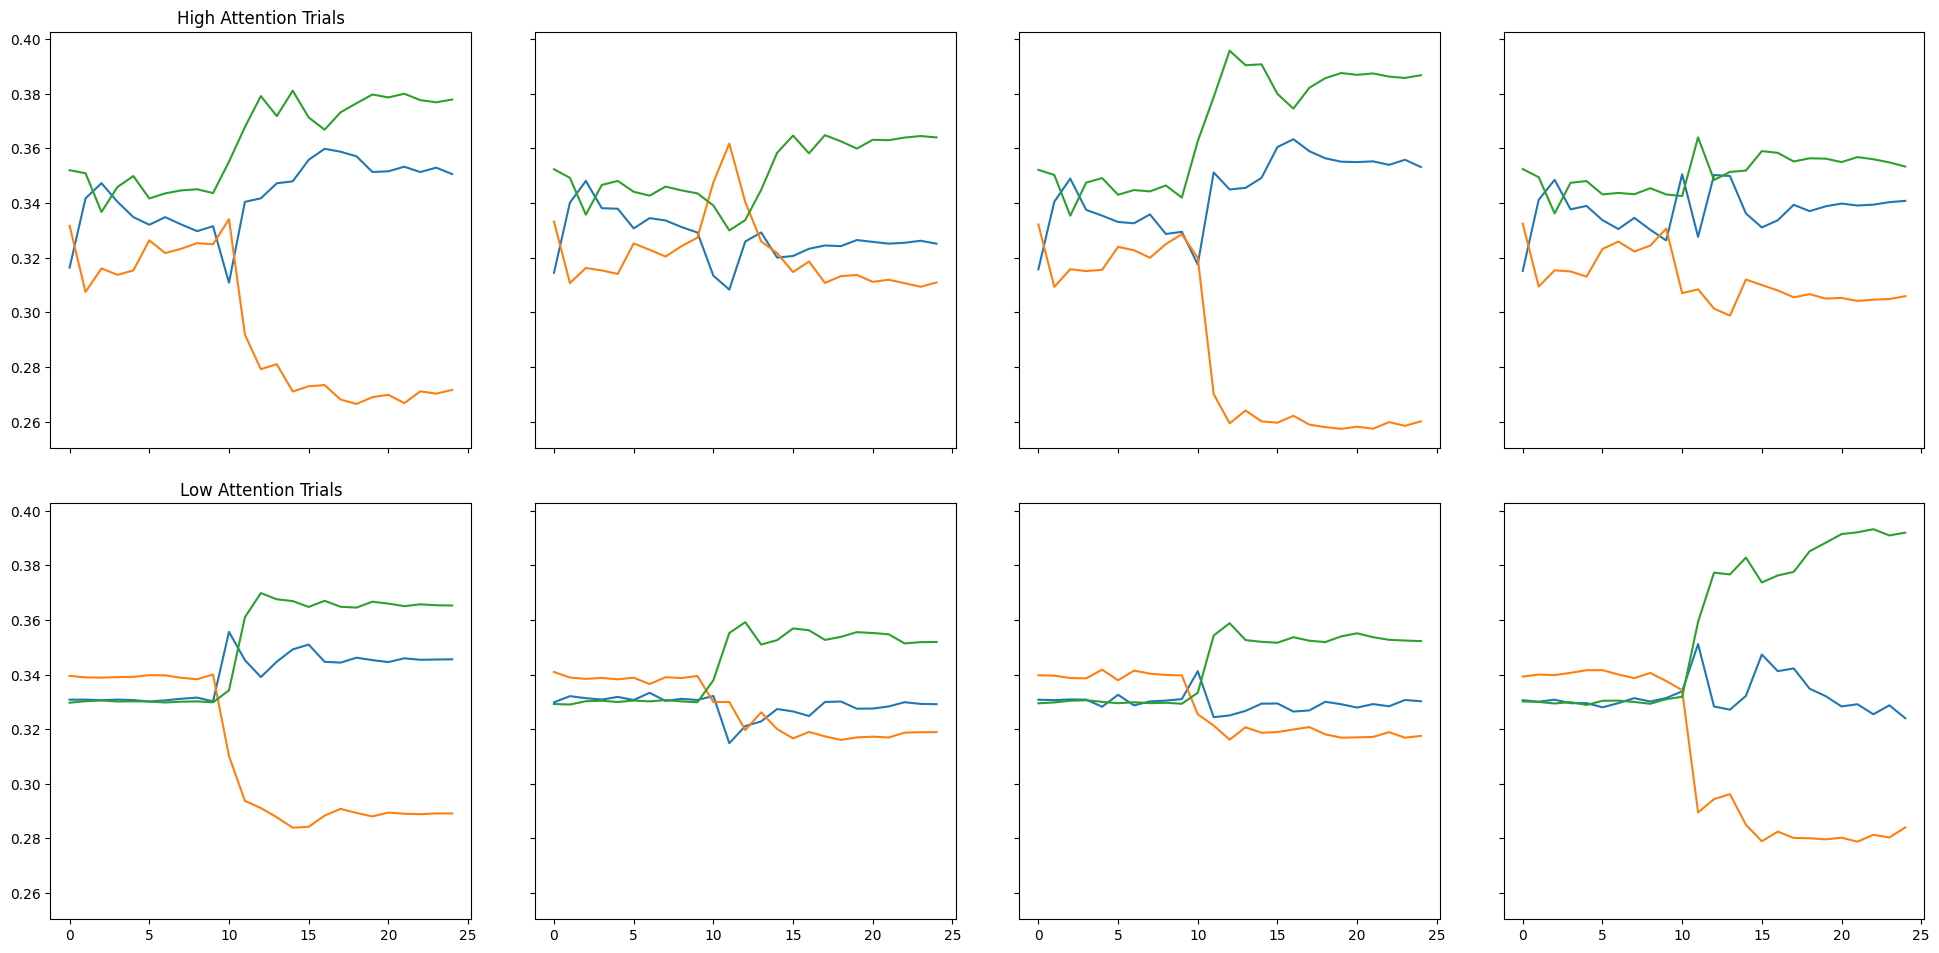

In [196]:
run = main()

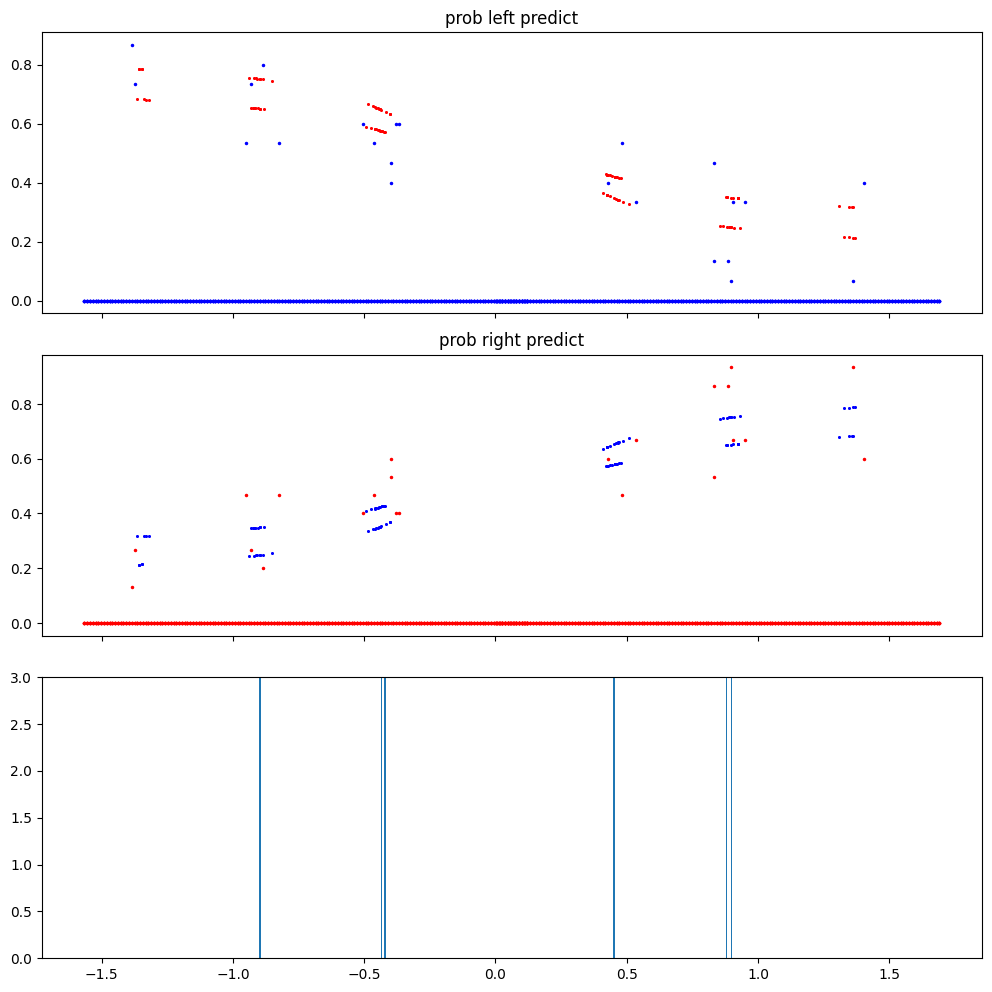

In [197]:
run.mod.plotPsychCurve()

[1, 17, 8, 2] index low attention trials plotted
[7, 15, 13, 6] index of high attention trials plotted
[2, 8, 5, 8] difficulty low attention trials plotted
[2, 8, 5, 8] difficulty high attention trials plotted


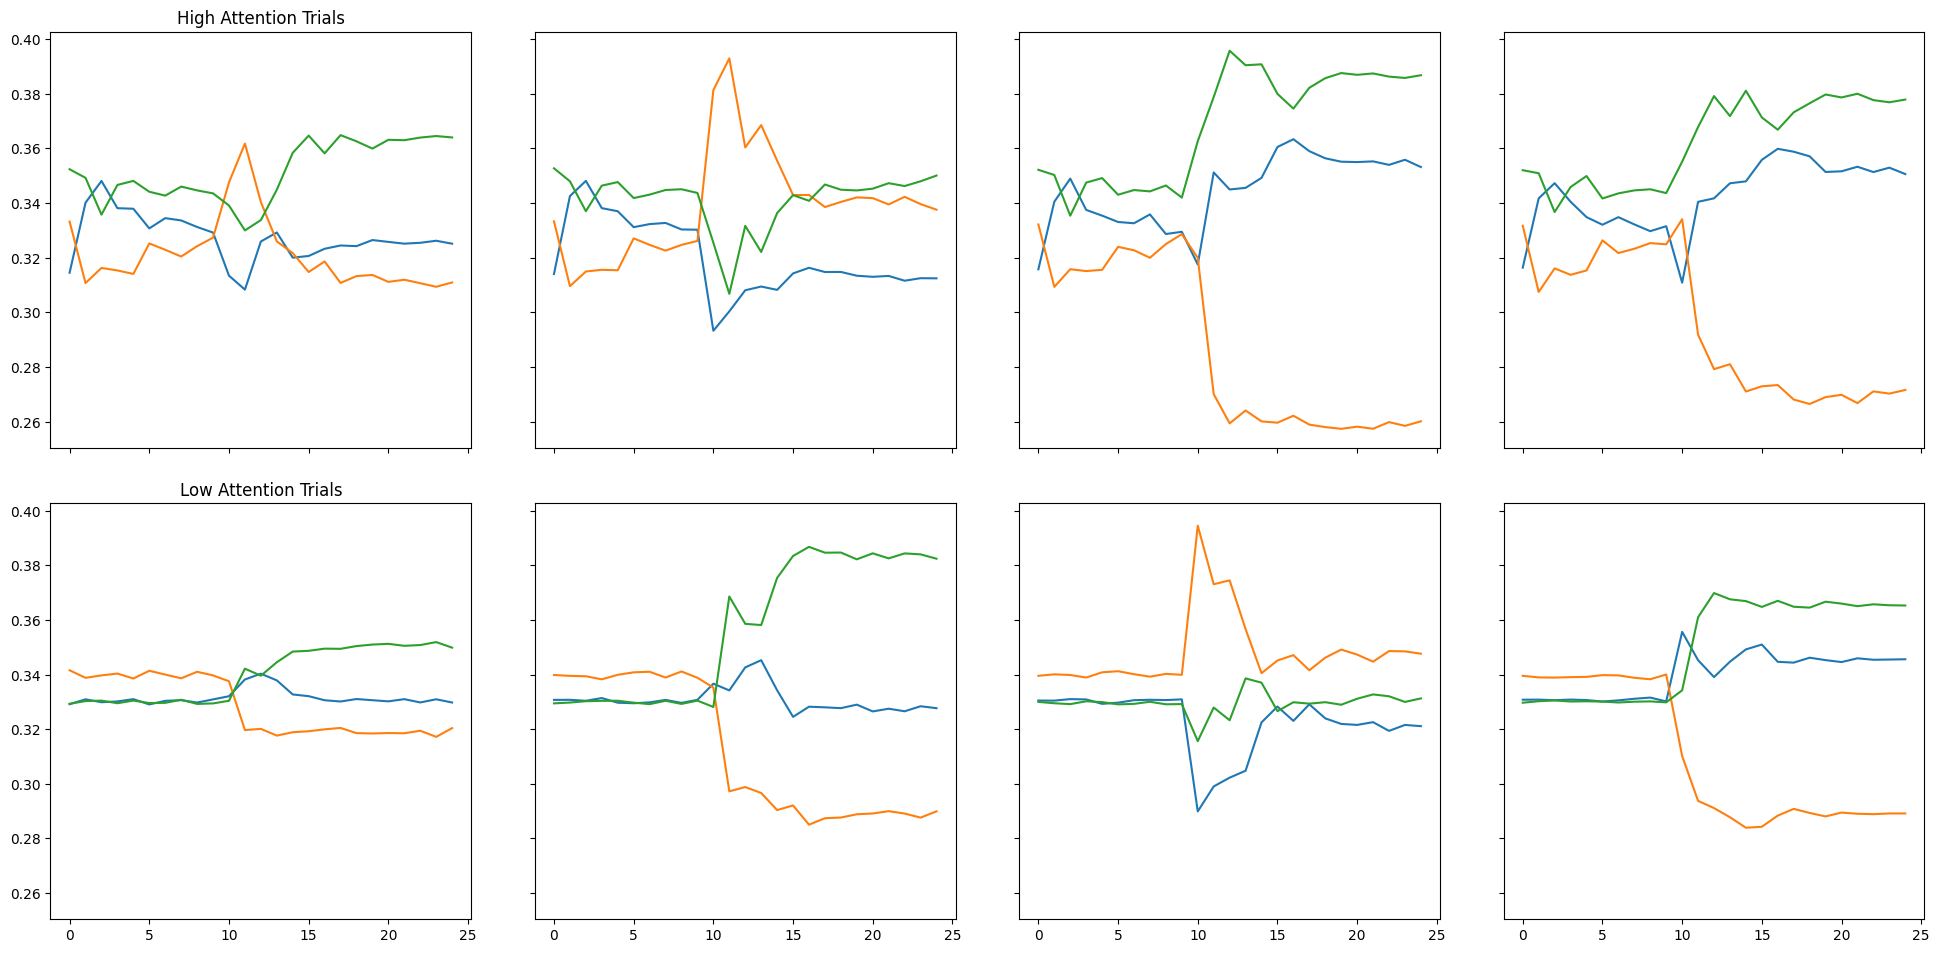

In [198]:
run.mod.plotTestResponse()

In [199]:
#%load_ext tensorboard

In [200]:
#%tensorboard --logdir logs/fit